# Lightweight Fine-Tuning Project

* PEFT technique: LORA will be used to inject layers into the model to see whether we can use this to improve the model. We will also try quantization and compare.
* Model: We will use bert-base-uncased as the max length of the data is appropriately sized.
* Evaluation approach: We will start by reviewing the data to understand the content and the labeling quality. The label library was sourced from the dataset card on huggingface. If satisfactory, we will consider any preprocessing requirements. Subsequently we will add a classification head to the model based on the remaining labels. That model will be evaluated without training to form a baseline. Afterwards, we will create a PEFT model from bert-base-uncased, with 3 experiments. 

  * Inject our matrices into attention layers
  * Inject our matrices into attention+dense layers
  * Use a quantized model and inject our matrices into dense layers

  For each trained configuration, we will perform inference and then compare evaluations across the set.
* Fine-tuning dataset: https://huggingface.co/datasets/banking77?ref=hackernoon.com&library=true

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [1]:
! pip install -q "datasets==2.15.0"
from pathlib import Path
import pandas as pd 
import numpy as np
import random
import shutil
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, BitsAndBytesConfig

from peft import LoraModel, LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
import torch


str_training_path = "./training"
str_model_path = "./model"
if not Path(str_training_path).exists():
    Path(str_training_path).mkdir(parents=True,exist_ok=True)
if not Path(str_training_path).exists():
    Path(str_training_path).mkdir(parents=True,exist_ok=True)
str_model_path_eval = "gpt-eval"
str_model_path_lora = "gpt-lora"
str_model_path_lora_all = "gpt-lora-all"
str_model_path_lqbit = "gpt-lqbit"

In [2]:
from datasets import load_dataset, Dataset

dataset = load_dataset("banking77")

splits = ["train", "test"]
dataset["train"]


Dataset({
    features: ['text', 'label'],
    num_rows: 10003
})

In [3]:
df_data=pd.DataFrame({'text':dataset['train']['text'],'label':dataset['train']['label']})
#load label translations manually sourced from the huggingface website
df_lib = pd.read_csv('./data/polyai_banking77_labels.csv',sep='\t')
df_trn = pd.merge(df_data,df_lib,on='label',how='inner')

In [4]:
df_trn.drop_duplicates(subset=['text'],inplace=True)
df_trn.dropna(subset=['text'],inplace=True)
df_trn['text_len'] = df_trn['text'].str.len()
int_shortest_text = df_trn['text_len'].min()
int_longest_text = df_trn['text_len'].max()
# df_trn.tail(5)

In [5]:
print(f"Shortest text is {int_shortest_text} characters and longest text is {int_longest_text} characters")

Shortest text is 13 characters and longest text is 433 characters


In [6]:
df_trn[df_trn['text_len'] >= .8*(int_longest_text)].sort_values(by=['text_len'],ascending=False)[['text','intent (category)','text_len']][:3].values.tolist()

[['Hearing back from us regarding your important verification results may take 10 minutes to one hour time.  If verification results do fail, double-check to make sure all of your images are clear --  make sure your photos have no glare or blurring. Note: These photos need to be readable as well.  You also need to be 18 years of age or older.  You must be a resident of Switzerland or the European Economic Area to open a new account.',
  'unable_to_verify_identity',
  433],
 ['Hearing about your verification results from us may take anywhere from 10 minutes to approximately one hour.  If this verification has in fact, failed, double-check to make sure that your images are clear.  Also make sure that your document photos have no blur or glare. They need to be readable.  You must also be 18 years of age or older and be a resident of Switzerland or the European Economic Area to open an account.',
  'unable_to_verify_identity',
  422],
 ["Hi! I'm a university student studying abroad and I n

In [7]:
df_trn[df_trn['text_len'] <= 1.2*(int_shortest_text)].sort_values(by=['text_len'],ascending=True)[['text','intent (category)','text_len']][:5].values.tolist()

[['Can I top up?', 'top_up_limits', 13],
 ['The card PIN?', 'get_physical_card', 13],
 ['wheres my pin', 'get_physical_card', 13],
 ['Lost password', 'passcode_forgotten', 13],
 ['phone is gone', 'lost_or_stolen_phone', 13]]

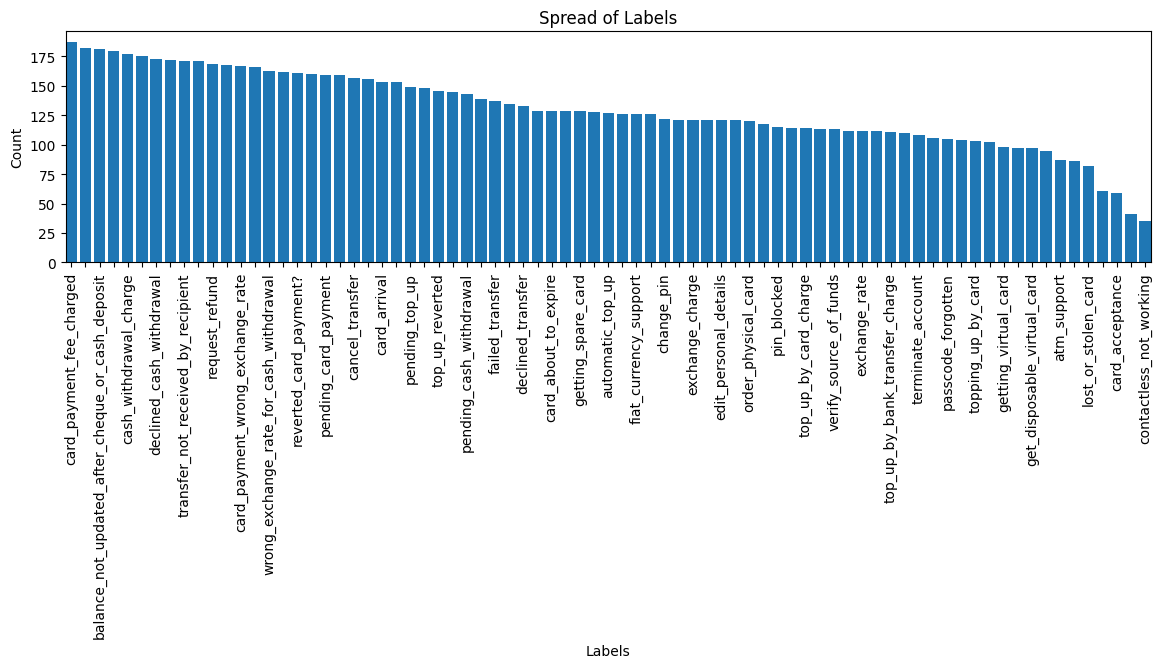

In [8]:
df_balcheck = df_trn.groupby('intent (category)').agg({'text':'count'}).reset_index(drop=False).rename(columns={'text':'count'}).sort_values(by='count',ascending=False)

dct_ticks={i:v if i % 2 == 0 else "" for i,v in enumerate(df_balcheck['intent (category)'].values)}
plt.figure(figsize=(14, 3))

plt.bar(df_balcheck['intent (category)'], df_balcheck['count'])
plt.xticks(ticks=list(dct_ticks.keys()), labels=list(dct_ticks.values()), rotation=90)

plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Spread of Labels")
plt.xlabel("Labels")
plt.ylabel("Count") 
plt.show()

In [9]:
dct_id2label = pd.Series(df_lib['intent (category)'].values, index=df_lib['label'].values).to_dict()
dct_label2id = pd.Series(df_lib['label'].values, index=df_lib['intent (category)'].values).to_dict()

# Tokenization of the data

In [10]:
str_model_touse = "bert-base-uncased"
# str_model_touse = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(str_model_touse)

tokenized_dataset = {}
for split in splits:
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["text"], truncation=True), batched=True
    )

tokenized_dataset["train"]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10003
})

In [11]:
tokenized_dataset["train"][random.randrange(0,len(tokenized_dataset["train"]))]

{'text': 'i want to get my salary deposited as pesos?',
 'label': 50,
 'input_ids': [101,
  1045,
  2215,
  2000,
  2131,
  2026,
  10300,
  14140,
  2004,
  21877,
  17063,
  1029,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Initialize base model

In [12]:

model_eval = AutoModelForSequenceClassification.from_pretrained(
    str_model_touse,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
)

for param in model_eval.parameters():
    param.require_grad = False
    
print(model_eval)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

# Read more about it here https://huggingface.co/docs/transformers/main_classes/trainer
trainer = Trainer(
    model=model_eval,
    args=TrainingArguments(
        output_dir=f"{str_training_path}/{str_model_path_eval}",
        # Set the learning rate
        learning_rate=5e-5,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        # Evaluate and save the model after each epoch
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        seed=42
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)


In [14]:
dct_rslt_pretrain = trainer.evaluate()
dct_rslt_pretrain

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 4.392544746398926,
 'eval_accuracy': 0.00909090909090909,
 'eval_runtime': 7.7666,
 'eval_samples_per_second': 396.571,
 'eval_steps_per_second': 6.309}

## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

### Lora Config - specific layers

In [15]:

model_base = AutoModelForSequenceClassification.from_pretrained(
    str_model_touse,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
)

for param in model_base.parameters():
    param.require_grad = True
    
print(model_base)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
config_lora = LoraConfig(task_type="SEQ_CLS", r=16, lora_alpha=32,
    bias='lora_only',
    inference_mode=False,
    target_modules=['query','key','value'],
    modules_to_save=["classifier"]
                   )


model_lora = get_peft_model(model_base, config_lora)
model_lora.print_trainable_parameters()

trainable params: 1,030,810 || all params: 110,485,402 || trainable%: 0.932982983580039


In [17]:
model_lora

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=F

In [18]:
str_dir = f"{str_training_path}/{str_model_path_lora}"
shutil.rmtree(str_dir)

lr = 5e-5
trainer_lora = Trainer(
    model=model_lora,
    args=TrainingArguments(
        output_dir=str_dir,
        # Set the learning rate
        learning_rate=lr,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        # Evaluate and save the model after each epoch
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        seed=42
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [19]:
trainer_lora.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.225300,3.814634,0.064610
2,3.719300,3.431990,0.114286
3,3.435800,3.316594,0.138312


TrainOutput(global_step=1878, training_loss=3.697563845763445, metrics={'train_runtime': 200.5867, 'train_samples_per_second': 149.606, 'train_steps_per_second': 9.363, 'total_flos': 614803400063580.0, 'train_loss': 3.697563845763445, 'epoch': 3.0})

In [20]:
str_dir = f"{str_model_path}/{str_model_path_lora}"
model_lora.save_pretrained(str_dir)

### Lora Config - all layers

In [21]:
model_base = AutoModelForSequenceClassification.from_pretrained(
    str_model_touse,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
)

for param in model_base.parameters():
    param.require_grad = True
    
print(model_base)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
config_lora_all = LoraConfig(task_type="SEQ_CLS", r=16, lora_alpha=32,
    bias='lora_only',
    inference_mode=False,
    target_modules=['query','key','value','dense'],
    modules_to_save=["classifier"]
                   )


model_lora_all = get_peft_model(model_base, config_lora_all)
model_lora_all.print_trainable_parameters()

trainable params: 2,880,922 || all params: 112,279,450 || trainable%: 2.5658497614657


In [23]:
model_lora_all

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=F

In [24]:
str_dir = f"{str_training_path}/{str_model_path_lora_all}"
shutil.rmtree(str_dir)

lr = 5e-5
trainer_lora_all = Trainer(
    model=model_lora_all,
    args=TrainingArguments(
        output_dir=str_dir,
        # Set the learning rate
        learning_rate=lr,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        # Evaluate and save the model after each epoch
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        seed=42
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [25]:
trainer_lora_all.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.077700,3.443943,0.147078
2,3.265600,2.709384,0.349351
3,2.722900,2.499639,0.434740


TrainOutput(global_step=1878, training_loss=3.1862831318848177, metrics={'train_runtime': 259.3946, 'train_samples_per_second': 115.689, 'train_steps_per_second': 7.24, 'total_flos': 627532655016540.0, 'train_loss': 3.1862831318848177, 'epoch': 3.0})

In [26]:
str_dir = f"{str_model_path}/{str_model_path_lora_all}"

model_lora_all.save_pretrained(str_dir)

### Quantized - all layers

In [27]:

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model_4bit = AutoModelForSequenceClassification.from_pretrained(
    str_model_touse,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
    quantization_config=quantization_config

)

for param in model_4bit.parameters():
    param.require_grad = True
    
print(model_4bit)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=True)
              (key): Linear4bit(in_features=768, out_features=768, bias=True)
              (value): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [28]:
import torch

model_4bit = prepare_model_for_kbit_training(model_4bit)

config_lqbit = LoraConfig(task_type="SEQ_CLS", r=16, lora_alpha=32,
    bias='lora_only',
    inference_mode=False,
    target_modules=['dense'],
#     target_modules=['query','key','value','dense'],

    modules_to_save=["classifier"],
                   )


lqbit_model = get_peft_model(model_4bit, config_lqbit)
lqbit_model.print_trainable_parameters()

trainable params: 1,968,538 || all params: 111,394,714 || trainable%: 1.7671736201055286


In [29]:
lqbit_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear4bit(in_features=768, out_features=768, bias=True)
                  (key): Linear4bit(in_features=768, out_features=768, bias=True)
                  (value): Linear4bit(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
         

In [30]:
str_dir = f"{str_training_path}/{str_model_path_lqbit}"
shutil.rmtree(str_dir)

lr = 5e-5
trainer_lqbit = Trainer(
    model=lqbit_model,
    args=TrainingArguments(
        output_dir=str_dir,
        # Set the learning rate
        learning_rate=lr,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        # Evaluate and save the model after each epoch
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        optim="paged_adamw_8bit",

        seed=42
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [31]:
trainer_lqbit.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.117900,3.213898,0.237338
2,3.023500,2.377640,0.462987
3,2.404700,2.170277,0.521429


TrainOutput(global_step=1878, training_loss=2.9809154311435035, metrics={'train_runtime': 382.1047, 'train_samples_per_second': 78.536, 'train_steps_per_second': 4.915, 'total_flos': 621255214217820.0, 'train_loss': 2.9809154311435035, 'epoch': 3.0})

In [32]:
str_dir = f"{str_model_path}/{str_model_path_lqbit}"

lqbit_model.save_pretrained(str_dir)

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

### Lora - specific

In [33]:
config = LoraConfig.from_json_file(f"{str_model_path}/{str_model_path_lora}/adapter_config.json")
config

{'auto_mapping': None,
 'base_model_name_or_path': 'bert-base-uncased',
 'bias': 'lora_only',
 'fan_in_fan_out': False,
 'inference_mode': True,
 'init_lora_weights': True,
 'layers_pattern': None,
 'layers_to_transform': None,
 'lora_alpha': 32,
 'lora_dropout': 0.0,
 'modules_to_save': ['classifier'],
 'peft_type': 'LORA',
 'r': 16,
 'revision': None,
 'target_modules': ['query', 'key', 'value'],
 'task_type': 'SEQ_CLS'}

In [34]:

config = PeftConfig.from_pretrained(f"{str_model_path}/{str_model_path_lora}")
model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
    ignore_mismatched_sizes=True
)

lora_model_pulled = PeftModel.from_pretrained(model, f"{str_model_path}/{str_model_path_lora}")

lora_model_pulled.eval()

print(lora_model_pulled)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=F

In [35]:
batch_size = 128
trainer = Trainer(
    model=lora_model_pulled,
    args=TrainingArguments(
        output_dir=f"{str_training_path}/{str_model_path_lora}",
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)


In [36]:
dct_rslt_posttrain_lora = trainer.evaluate()
dct_rslt_posttrain_lora

{'eval_loss': 3.316593885421753,
 'eval_accuracy': 0.1383116883116883,
 'eval_runtime': 9.0068,
 'eval_samples_per_second': 341.965,
 'eval_steps_per_second': 2.776}

### Lora - all layers

In [37]:
config = LoraConfig.from_json_file(f"{str_model_path}/{str_model_path_lora_all}/adapter_config.json")
config

{'auto_mapping': None,
 'base_model_name_or_path': 'bert-base-uncased',
 'bias': 'lora_only',
 'fan_in_fan_out': False,
 'inference_mode': True,
 'init_lora_weights': True,
 'layers_pattern': None,
 'layers_to_transform': None,
 'lora_alpha': 32,
 'lora_dropout': 0.0,
 'modules_to_save': ['classifier'],
 'peft_type': 'LORA',
 'r': 16,
 'revision': None,
 'target_modules': ['query', 'key', 'value', 'dense'],
 'task_type': 'SEQ_CLS'}

In [38]:

config = PeftConfig.from_pretrained(f"{str_model_path}/{str_model_path_lora_all}")
model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
    ignore_mismatched_sizes=True
)

lora_model_pulled = PeftModel.from_pretrained(model, f"{str_model_path}/{str_model_path_lora_all}")

lora_model_pulled.eval()

print(lora_model_pulled)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=F

In [39]:
batch_size = 128
trainer = Trainer(
    model=lora_model_pulled,
    args=TrainingArguments(
        output_dir=f"{str_training_path}/{str_model_path_lora_all}",
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)


In [40]:
dct_rslt_posttrain_lora_all = trainer.evaluate()
dct_rslt_posttrain_lora_all

{'eval_loss': 2.499638795852661,
 'eval_accuracy': 0.43474025974025976,
 'eval_runtime': 9.9472,
 'eval_samples_per_second': 309.636,
 'eval_steps_per_second': 2.513}

### Quantized

In [41]:
config = LoraConfig.from_json_file(f"{str_model_path}/{str_model_path_lqbit}/adapter_config.json")
config

{'auto_mapping': None,
 'base_model_name_or_path': 'bert-base-uncased',
 'bias': 'lora_only',
 'fan_in_fan_out': False,
 'inference_mode': True,
 'init_lora_weights': True,
 'layers_pattern': None,
 'layers_to_transform': None,
 'lora_alpha': 32,
 'lora_dropout': 0.0,
 'modules_to_save': ['classifier'],
 'peft_type': 'LORA',
 'r': 16,
 'revision': None,
 'target_modules': ['dense'],
 'task_type': 'SEQ_CLS'}

In [42]:

config = PeftConfig.from_pretrained(f"{str_model_path}/{str_model_path_lqbit}")
model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=len(dct_id2label.keys()),
    id2label=dct_id2label,
    label2id=dct_label2id,
    ignore_mismatched_sizes=True,
    quantization_config=quantization_config

)

lqbit_model_pulled = PeftModel.from_pretrained(model, f"{str_model_path}/{str_model_path_lqbit}")

lqbit_model_pulled.eval()

print(lqbit_model_pulled)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear4bit(in_features=768, out_features=768, bias=True)
                  (key): Linear4bit(in_features=768, out_features=768, bias=True)
                  (value): Linear4bit(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
         

In [43]:
batch_size = 128
trainer = Trainer(
    model=lqbit_model_pulled,
    args=TrainingArguments(
        output_dir=f"{str_training_path}/{str_model_path_lqbit}",
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)


In [44]:
dct_rslt_posttrain_lqbit = trainer.evaluate()
dct_rslt_posttrain_lqbit

{'eval_loss': 2.169921875,
 'eval_accuracy': 0.522077922077922,
 'eval_runtime': 12.5299,
 'eval_samples_per_second': 245.813,
 'eval_steps_per_second': 1.995}

# Comparison

In [45]:
pd.DataFrame([dct_rslt_pretrain,dct_rslt_posttrain_lora,dct_rslt_posttrain_lora_all,dct_rslt_posttrain_lqbit], 
             index=['pretrain','lora','lora_all','lora_qbit'])

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
pretrain,4.392545,0.009091,7.7666,396.571,6.309
lora,3.316594,0.138312,9.0068,341.965,2.776
lora_all,2.499639,0.434740,9.9472,309.636,2.513
lora_qbit,2.169922,0.522078,12.5299,245.813,1.995




# References used

* https://huggingface.co/datasets?task_categories=task_categories:text-classification
* https://huggingface.co/docs/transformers/v4.39.0/en/main_classes/model#transformers.PreTrainedModel.save_pretrained
* https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/model#transformers.PreTrainedModel.from_pretrained
* https://huggingface.co/docs/peft/index
* https://huggingface.co/docs/peft/quicktour
* https://www.linkedin.com/pulse/fine-tuning-language-model-peft-lora-bitsandbytes-ola-magnusson-v0ptf


* https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora
* https://huggingface.co/docs/peft/v0.10.0/en/package_reference/lora#peft.LoraConfig
* https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

* https://huggingface.co/docs/bitsandbytes/main/en/integrations
* https://huggingface.co/docs/transformers/quantization#bitsandbytes
* https://huggingface.co/docs/peft/developer_guides/quantization#quantization
* https://github.com/huggingface/peft/blob/main/examples/loftq_finetuning/LoftQ_weight_replacement.ipynb
* https://huggingface.co/blog/4bit-transformers-bitsandbytes
* https://github.com/huggingface/peft/tree/main/examples/loftq_finetuning
